In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import sklearn
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from scipy.fft import fft
from dateutil.relativedelta import relativedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os

In [2]:
#Define a function that offsets all repeating WaterYear values
def duplicate_years(df):
    # Create a set to keep track of seen values and a dictionary for offsets
    seen = set()
    offsets = {}
    append = 0

    # Increment duplicates
    for idx, year in enumerate(df['WaterYear']):
        if year in seen:
            # Increment the year using the current offset for this value
            offsets[year] += 1
            df.at[idx, 'WaterYear'] = int(year + offsets[year])
        else:
            # First occurrence, initialize offset
            seen.add(year)
            offsets[year] = 0

    df['WaterYear'] = df['WaterYear'].astype('int')
    return df

In [3]:
# Load data
data = pd.read_csv('../Data/final_data_temp.csv')

In [4]:
# Convert WaterYear to date time format and set as index
data["Date"] = pd.to_datetime(data["WaterYear"].astype(str) + "-10-01")
data.set_index("Date", inplace=True)
grouped_data = data.groupby("County")

In [5]:
# Ensure the forecast directory exists
#output_dir = "../Station_Forecasts"
#os.makedirs(output_dir, exist_ok=True)
new_stations = []

In [10]:
# Loop through each unique station and create a model - SARIMAX
for station in list(grouped_data):
    station_name = station[0]
    station = station[1]
    # Resample Station data to ensure consistent frequency and fill any missing dates
    station = duplicate_years(station)
    station.index = pd.to_datetime(station["WaterYear"].astype(str) + "-10-01")
    try:
        station = station.resample("YS-OCT").asfreq()
    except:
        print(station.to_string())

    # Append new stations array for future analysis
    new_stations.append(station)

    # Train SARIMAX model with reduced complexity for sparse data
    model = SARIMAX(
        station["TotalPrecipitation_inches"],
        order=(1, 1, 1),
        seasonal_order=(0, 1, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False,
    )
    sarima_model = model.fit(disp=False)

    # Predict future precipitation values
    predict_years = 80
    pred = sarima_model.get_forecast(steps=predict_years)
    pred_vals = pred.predicted_mean
    pred_ci = pred.conf_int()

    # Create a forecast index based on the last known date and desired frequency
    pred_index = pd.date_range(
        start=station.index[-1] + pd.DateOffset(years=1),
        periods=predict_years,
        freq="AS-Oct",
    )

    # Create forecast series and assign the forecast index
    forecast_series = pd.Series(pred_vals.values, index=pred_index)

    # Adjust the confidence interval index to match forecast index
    forecast_ci = pred_ci.set_index(pred_index)

    # Combine forecast series and confidence interval
    rainfall_forecast_series = pd.concat([forecast_series, forecast_ci], axis=1)

    # Save forecast data to a text file
    with open(f"../County_Forecasts/{station_name}_forecast.txt", "w") as f:
        f.write(f"Precipitation Forecast for {station_name} County:\n")
        for row in rainfall_forecast_series.itertuples():
            # Check if row.Index is a datetime object
            if isinstance(row.Index, pd.Timestamp):
                f.write(
                    f"{row.Index.strftime('%Y-%m-%d')}: Prediction: {row[1]:.2f} inches, "
                    f"Lower {row[2]:.2f} inches, Upper {row[3]:.2f} inches\n"
                )
            else:
                f.write(
                    f"{row.Index}: Prediction: {row[1]:.2f} inches, "
                    f"Lower {row[2]:.2f} inches, Upper {row[3]:.2f} inches\n"
                )

    print(
        f"Forecast for {station_name} Station saved to ../County_Forecasts/{station_name}_forecast.txt"
    )

               StationName  County  TotalPrecipitation_inches  WaterYear     x_coord    y_coord
WaterYear                                                                                      
1961-10-01  Plaskett Meadow   Glen                      48.30       1961 -122.857873  39.735429
1962-10-01  Plaskett Meadow   Glen                      49.04       1962 -122.857873  39.735429
1963-10-01  Plaskett Meadow   Glen                      54.24       1963 -122.857873  39.735429
1964-10-01  Plaskett Meadow   Glen                      45.55       1964 -122.857873  39.735429
1965-10-01  Plaskett Meadow   Glen                      93.25       1965 -122.857873  39.735429
1966-10-01  Plaskett Meadow   Glen                      46.45       1966 -122.857873  39.735429
1967-10-01  Plaskett Meadow   Glen                      66.24       1967 -122.857873  39.735429
1968-10-01  Plaskett Meadow   Glen                      50.66       1968 -122.857873  39.735429
1969-10-01  Plaskett Meadow   Glen      

C:\Users\dfang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\dfang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)


                StationName   County  TotalPrecipitation_inches  WaterYear     x_coord    y_coord
WaterYear                                                                                        
1948-10-01   Blacks Mountain  Lassen                  25.120000       1948 -121.199842  40.770035
1949-10-01   Blacks Mountain  Lassen                  16.000000       1949 -121.199842  40.770035
1950-10-01   Blacks Mountain  Lassen                  21.360000       1950 -121.199842  40.770035
1951-10-01   Blacks Mountain  Lassen                  22.030000       1951 -121.199842  40.770035
1952-10-01   Blacks Mountain  Lassen                  28.060000       1952 -121.199842  40.770035
1953-10-01   Blacks Mountain  Lassen                  22.530000       1953 -121.199842  40.770035
1954-10-01   Blacks Mountain  Lassen                  18.070000       1954 -121.199842  40.770035
1955-10-01   Blacks Mountain  Lassen                  14.060000       1955 -121.199842  40.770035
1956-10-01   Blacks 

C:\Users\dfang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dfang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dfang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_d

Forecast for Lassen Station saved to ../County_Forecasts/Lassen_forecast.txt
                 StationName  County  TotalPrecipitation_inches  WaterYear     x_coord    y_coord
WaterYear                                                                                        
1960-10-01       Crowder Flat  Modoc                     13.270       1960 -120.733770  41.899319
1961-10-01       Crowder Flat  Modoc                     14.150       1961 -120.733770  41.899319
1962-10-01       Crowder Flat  Modoc                     13.810       1962 -120.733770  41.899319
1963-10-01       Crowder Flat  Modoc                     20.110       1963 -120.733770  41.899319
1964-10-01       Crowder Flat  Modoc                     16.720       1964 -120.733770  41.899319
1965-10-01       Crowder Flat  Modoc                     22.900       1965 -120.733770  41.899319
1966-10-01       Crowder Flat  Modoc                     12.850       1966 -120.733770  41.899319
1967-10-01       Crowder Flat  Modoc     

C:\Users\dfang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dfang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dfang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_d

Forecast for Modoc Station saved to ../County_Forecasts/Modoc_forecast.txt
                  StationName   County  TotalPrecipitation_inches  WaterYear     x_coord    y_coord
WaterYear                                                                                          
1970-10-01       Boulder Creek  Plumas                  30.450000       1970 -121.199842  40.770035
1971-10-01       Boulder Creek  Plumas                  35.380000       1971 -121.199842  40.770035
1972-10-01       Boulder Creek  Plumas                  21.120000       1972 -121.199842  40.770035
1973-10-01       Boulder Creek  Plumas                  22.070000       1973 -121.199842  40.770035
1974-10-01       Boulder Creek  Plumas                  35.070000       1974 -121.199842  40.770035
1975-10-01       Boulder Creek  Plumas                  27.890000       1975 -121.199842  40.770035
1976-10-01       Boulder Creek  Plumas                  16.830000       1976 -121.199842  40.770035
1977-10-01       Boulder 

C:\Users\dfang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dfang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dfang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_d

Forecast for Plumas Station saved to ../County_Forecasts/Plumas_forecast.txt
             StationName   County  TotalPrecipitation_inches  WaterYear     x_coord    y_coord
WaterYear                                                                                     
1947-10-01  Stouts Meadow  Shasta                      68.17       1947 -121.939585  41.168906
1948-10-01  Stouts Meadow  Shasta                      89.91       1948 -121.939585  41.168906
1949-10-01  Stouts Meadow  Shasta                      60.55       1949 -121.939585  41.168906
1950-10-01  Stouts Meadow  Shasta                      57.50       1950 -121.939585  41.168906
1951-10-01  Stouts Meadow  Shasta                     109.70       1951 -121.939585  41.168906
1952-10-01  Stouts Meadow  Shasta                     109.16       1952 -121.939585  41.168906
1953-10-01  Stouts Meadow  Shasta                      88.50       1953 -121.939585  41.168906
1954-10-01  Stouts Meadow  Shasta                      41.10       1

C:\Users\dfang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dfang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dfang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_d

Forecast for Siskiyou Station saved to ../County_Forecasts/Siskiyou_forecast.txt
              StationName   County  TotalPrecipitation_inches  WaterYear     x_coord    y_coord
WaterYear                                                                                      
1951-10-01   Ball Mountain  Tehama                  39.510000       1951 -122.780911  39.936369
1952-10-01   Ball Mountain  Tehama                  42.650000       1952 -122.780911  39.936369
1953-10-01   Ball Mountain  Tehama                  44.090000       1953 -122.780911  39.936369
1954-10-01   Ball Mountain  Tehama                  41.920000       1954 -122.780911  39.936369
1955-10-01   Ball Mountain  Tehama                  28.420000       1955 -122.780911  39.936369
1956-10-01   Ball Mountain  Tehama                  58.650000       1956 -122.780911  39.936369
1957-10-01   Ball Mountain  Tehama                  30.180000       1957 -122.780911  39.936369
1958-10-01   Ball Mountain  Tehama                  64.

C:\Users\dfang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dfang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dfang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_d

Forecast for Tehama Station saved to ../County_Forecasts/Tehama_forecast.txt
           StationName    County  TotalPrecipitation_inches  WaterYear    x_coord    y_coord
WaterYear                                                                                   
1947-10-01  Mumbo Basin  Trinity                      40.46       1947 -122.52525  41.197907
1948-10-01  Mumbo Basin  Trinity                      61.68       1948 -122.52525  41.197907
1949-10-01  Mumbo Basin  Trinity                      42.86       1949 -122.52525  41.197907
1950-10-01  Mumbo Basin  Trinity                      33.40       1950 -122.52525  41.197907
1951-10-01  Mumbo Basin  Trinity                      56.61       1951 -122.52525  41.197907
1952-10-01  Mumbo Basin  Trinity                      58.75       1952 -122.52525  41.197907
1953-10-01  Mumbo Basin  Trinity                      67.63       1953 -122.52525  41.197907
1954-10-01  Mumbo Basin  Trinity                      67.80       1954 -122.52525  41.

In [11]:
# Creating lag features for time-series data
def create_lag_features(data, lag_steps=1):
    for i in range(1, lag_steps + 1):
        data[f'lag_{i}'] = data["TotalPrecipitation_inches"].shift(i)
    return data

In [12]:
# Creating rolling mean for time-series data
def create_rolling_mean(data, window_size=3):
    data['rolling_mean'] = data["TotalPrecipitation_inches"].rolling(window=window_size).mean()
    return data

In [13]:
# Applying Fourier transformation for capturing seasonality
def apply_fourier_transform(data):
    values = data['TotalPrecipitation_inches'].values
    fourier_transform = fft(values)
    data['fourier_transform'] = np.abs(fourier_transform)
    return data

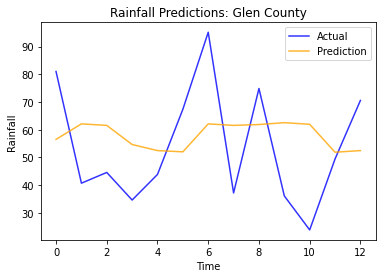

C:\Users\dfang\AppData\Local\Temp\ipykernel_1308\2114243854.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rolling_mean'] = data["TotalPrecipitation_inches"].rolling(window=window_size).mean()


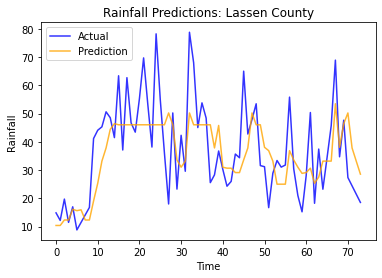

C:\Users\dfang\AppData\Local\Temp\ipykernel_1308\2114243854.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rolling_mean'] = data["TotalPrecipitation_inches"].rolling(window=window_size).mean()


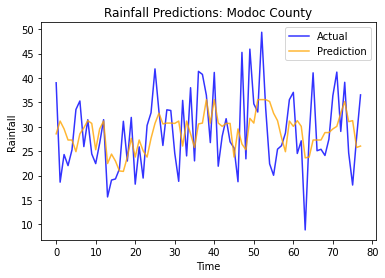

C:\Users\dfang\AppData\Local\Temp\ipykernel_1308\2114243854.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rolling_mean'] = data["TotalPrecipitation_inches"].rolling(window=window_size).mean()


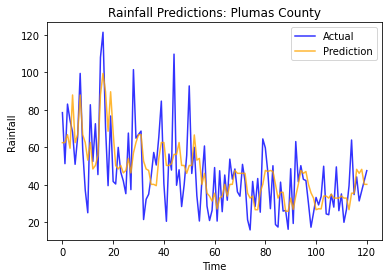

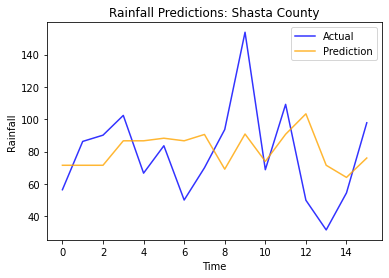

C:\Users\dfang\AppData\Local\Temp\ipykernel_1308\2114243854.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rolling_mean'] = data["TotalPrecipitation_inches"].rolling(window=window_size).mean()


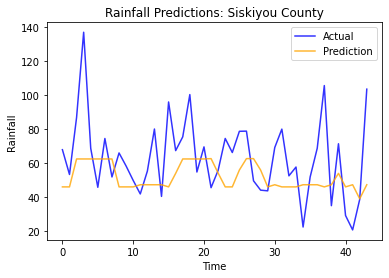

C:\Users\dfang\AppData\Local\Temp\ipykernel_1308\2114243854.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rolling_mean'] = data["TotalPrecipitation_inches"].rolling(window=window_size).mean()


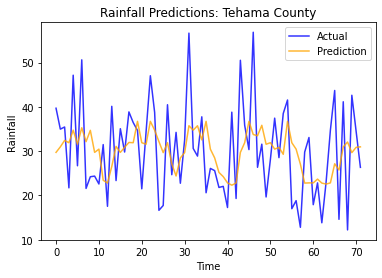

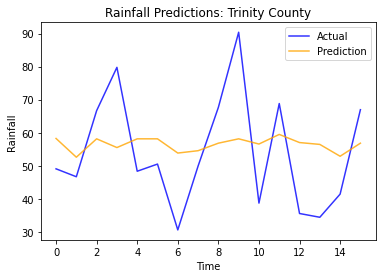

In [ ]:
errors_list = []
predictions_list = []
station_names = []
for station in list(grouped_data):
    station_maes = []
    station_rmses = []

    station_name = station[0]
    station_names.append(station_name)
    station = station[1]
    # Resample Station data to ensure consistent frequency and fill any missing dates
    station = duplicate_years(station)
    station = station.dropna()
    station.index = pd.to_datetime(station["WaterYear"].astype(str) + "-10-01")
    '''
    try:
        station = station.resample("YS-OCT").asfreq()
    except:
        print(station.to_string())
    '''

    # Applying lag feature creation to the dataset
    #station = create_lag_features(station, lag_steps = 5)
    # Applying rolling mean to the dataset
    station = create_rolling_mean(station, window_size = 5)
    #station = apply_fourier_transform(station)

    #X1 = station[['lag_1', 'lag_2', 'lag_3']]
    X2 = station['rolling_mean'] #We picked the rolling mean because precipitation data is susceptible to unnecessary trends (record high/low rainfall years)
    #X3 = station['fourier_transform']
    y = station['TotalPrecipitation_inches']

    X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, shuffle=False)

    param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0]
    }
    grid_search = GridSearchCV(XGBRegressor(), param_grid, cv=3)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_

    # Training the XGBoost model
    xgb_model = XGBRegressor(**best_params)
    xgb_model.fit(X_train, y_train)

    # Evaluating the XGBoost model on the testing set
    predictions = xgb_model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))

    errors_list.append([mae, rmse])

    #plt.plot(y_train.values, label = 'Training', color = 'green', alpha = 0.8)

    # Plot actual values
    plt.plot(y_test.values, label='Actual', color='blue', alpha=0.8)

    # Plot predicted values
    plt.plot(predictions, label='Prediction', color='orange', alpha=0.8)

    plt.xlabel('Time')
    plt.ylabel('Rainfall')
    plt.title('Rainfall Predictions: {} County'.format(station_name))
    plt.legend()
    plt.show()

In [18]:
for group_name, group_df in grouped_data:
    print(f"Group: {group_name}")
    print(group_df)
    print()

Group: Glen
               StationName  County  TotalPrecipitation_inches  WaterYear  \
Date                                                                       
1961-10-01  Plaskett Meadow   Glen                      48.30       1961   
1962-10-01  Plaskett Meadow   Glen                      49.04       1962   
1963-10-01  Plaskett Meadow   Glen                      54.24       1963   
1964-10-01  Plaskett Meadow   Glen                      45.55       1964   
1965-10-01  Plaskett Meadow   Glen                      93.25       1965   
...                     ...    ...                        ...        ...   
2019-10-01  Plaskett Meadow   Glen                      74.88       2019   
2020-10-01  Plaskett Meadow   Glen                      36.06       2020   
2021-10-01  Plaskett Meadow   Glen                      23.77       2021   
2022-10-01  Plaskett Meadow   Glen                      49.41       2022   
2023-10-01  Plaskett Meadow   Glen                      70.56       2023   


The discrepancies in the length of the XGBoost temperature indices stem from the length of the county data.

In [22]:
new_df = pd.DataFrame(errors_list, columns = ['mae', 'rmse'])
print(new_df.to_string())

         mae       rmse
0  20.214743  22.219988
1   9.973390  12.717284
2   5.979658   7.327359
3  12.335646  15.620829
4  23.883549  28.715490
5  19.043481  24.768876
6   8.242904   9.754127
7  14.302470  16.297875
